In [1]:
from collections import defaultdict

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline


import flotilla
sns.set(style='ticks', context='talk')

folder = '/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure1_expression'

study = flotilla.embark('singlecell_pnm')

/home/obotvinnik/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:784: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/obotvinnik/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())
/home/obotvinnik/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


2015-10-19 09:47:23	Reading datapackage from /home/obotvinnik/flotilla_projects/singlecell_pnm/datapackage.json
2015-10-19 09:47:23	Parsing datapackage to create a Study object
2015-10-19 09:48:03	Initializing Study
2015-10-19 09:48:03	Initializing Predictor configuration manager for Study
2015-10-19 09:48:03	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2015-10-19 09:48:03	Added ExtraTreesClassifier to default predictors
2015-10-19 09:48:03	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2015-10-19 09:48:03	Added ExtraTreesRegressor to default predictors
2015-10-19 09:48:03	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2015-10-19 09:48:03	Added GradientBoostingClassifier to default predictors
2015-10-19 09:48:03	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostin

In [2]:
study.splicing.data.head()

,exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-,exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514391:+,exon:chr10:101507014-101507147:+@exon:chr10:101514286-101514391:+@exon:chr10:101515382-101515891:+,exon:chr10:101964263-101964414:-@exon:chr10:101961845-101961906:-@exon:chr10:101960428-101960537:-,exon:chr10:101997779-101997988:-@exon:chr10:101996607-101996726:-@exon:chr10:101995424-101995521:-,exon:chr10:102003455-102003529:-@exon:chr10:101997779-101997988:-@exon:chr10:101996607-101996726:-,exon:chr10:102013178-102013296:-@exon:chr10:102010005-102010089:-@exon:chr10:102006552-102006692:-,exon:chr10:102019975-102020076:-@exon:chr10:102016019-102016233:-@exon:chr10:102013178-102013296:-,...,exon:chrX:102940099-102940188:-@exon:chrX:102939609-102939657:-@exon:chrX:102933427-102933528:-@exon:chrX:102930424-102931979:-,exon:chrX:102940099-102940433:-@exon:chrX:102939609-102939657:-@exon:chrX:102933427-102933548:-@exon:chrX:102930424-102931979:-,exon:chrX:102940099-102940188:-@exon:chrX:102939609-102939657:-@exon:chrX:102933427-102933579:-@exon:chrX:102930424-102931979:-,exon:chrX:129299525-129299853:-@exon:chrX:129290435-129290577:-@exon:chrX:129289131-129289261:-@exon:chrX:129283444-129283543:-,exon:chrX:138820075-138820228:-@exon:chrX:138814594-138814684:-@exon:chrX:138813810-138813914:-@exon:chrX:138808505-138811121:-,exon:chrX:138820075-138820228:-@exon:chrX:138819890-138819955:-@exon:chrX:138813810-138813914:-@exon:chrX:138808505-138811121:-,exon:chrX:16870872-16870998:-@exon:chrX:16870674-16870751:-@exon:chrX:16870539-16870673:-@exon:chrX:16870169-16870245:-,exon:chrX:69674946-69675113:+@exon:chrX:69675637-69675952:+@exon:chrX:69699000-69699114:+@exon:chrX:69711957-69712087:+,exon:chrX:73164419-73164497:+@exon:chrX:73166834-73167209:+@exon:chrX:73214675-73214796:+@exon:chrX:73218603-73218679:+,exon:chrX:73164419-73164497:+@exon:chrX:73214675-73214796:+@exon:chrX:73218603-73218679:+@exon:chrX:73224105-73224186:+
CVN_01,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN
CVN_02,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,1,NaN,NaN,1
CVN_03,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
CVN_04,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
CVN_05,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,1,NaN,NaN,1,NaN,NaN,NaN


In [3]:
study.splicing.data.shape

(233, 12265)

In [4]:
study.splicing.data_original.shape

(233, 25836)

### Reads mapped

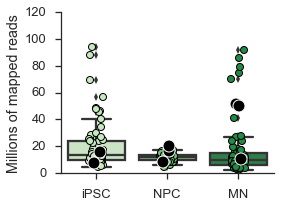

In [5]:
sns.set(style='ticks', context='talk')
millions_mapped = study.mapping_stats.number_mapped/1e6
millions_mapped = millions_mapped.to_frame().join(study.metadata.data[['pooled', 'phenotype']])

millions_mapped_pooled = millions_mapped.ix[millions_mapped.pooled]
millions_mapped_single = millions_mapped.ix[~millions_mapped.pooled]

fig, ax = plt.subplots(figsize=(4, 3))
sns.boxplot(x='phenotype', y='Uniquely mapped reads number', order=study.phenotype_order, 
               data=millions_mapped_single, palette=study.phenotype_color_ordered)
sns.stripplot(x='phenotype', y='Uniquely mapped reads number', order=study.phenotype_order,
               data=millions_mapped_single, palette=study.phenotype_color_ordered, jitter=True, edgecolor='k')
sns.stripplot(x='phenotype', y='Uniquely mapped reads number', order=study.phenotype_order,
              data=millions_mapped_pooled, color='k', size=12, jitter=True)
sns.despine()
ax.set_xlabel('')
ax.set_ylabel('Millions of mapped reads')
ymin, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)
fig.tight_layout()
fig.savefig("/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure1_expression/mapped_reads_violins.pdf")

## Predict outliers of celltype using $k$-means outliers

In [6]:
%%time
from sklearn.cluster import KMeans

#
expression_singles = study.expression.singles.dropna(axis=0, how='all')

# run k-means clustering
km = KMeans(init='k-means++', n_clusters=3, n_init=1000)
km.fit(expression_singles)


CPU times: user 4min 48s, sys: 113 ms, total: 4min 48s
Wall time: 4min 49s


### Determine group membership

In [7]:
from collections import defaultdict

# determine group membership
 
km_membership = dict(zip(expression_singles.index, km.labels_))
 
km_groups = defaultdict(list)
for sample in km_membership:
    km_groups[km_membership[sample]].append(study.sample_id_to_phenotype[sample])
    
# determine group outliers based on majority membership of cell type
km_outliers = []
 
km_colors = []
group_to_color = {}
for label in km_groups:
    lst = km_groups[label]
    most_common =  max(set(lst), key=lst.count)
    for sample in km_membership:
        sample_phenotype = study.sample_id_to_phenotype[sample]
        if sample_phenotype != most_common and km_membership[sample] == label:
            km_outliers.append(sample)

for x in sorted(km_outliers):
    print x

M1_03
M1_04
M2_01
M2_02
M2_06
M2_07
M3_01
M3_03
M4_13
M6_02
N1_06
N1_09
N2_06
N4_10
P2_06


Remove the outliers

In [8]:
study.metadata.data['outlier'] = study.metadata.data.index.isin(km_outliers)
study.drop_outliers()
study.save('singlecell_pnm_figure1_post_kmeans_outliers')

Wrote datapackage to /home/obotvinnik/flotilla_projects/singlecell_pnm_figure1_post_kmeans_outliers/datapackage.json


In [9]:
study.splicing.data.shape

(233, 12265)

In [10]:
study.splicing.data_original.shape

(233, 25836)